In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nibabel as nib
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import zoom
from tabulate import tabulate

sys.path.insert(0,"/analysis/ritter/AD/Budding_Spectral_Analysis/code/nitorch/")
from nitorch.data import load_nifti

In [2]:
working_dir = "/analysis/ritter/data/ADNI/ADNI_BIDS_skull_stripped"
## This project does not use downsized images 
z_factor = 0.525

In [3]:
# comment in relevant data 
# data_training = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/data_test_model/ADNI_training_set_4.csv', delimiter = ',')
# data_holdout = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/data_test_model/ADNI_holdout.csv', delimiter = ',')
# data_validation = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/data_test_model/ADNI_validation_set_4.csv', delimiter = ',')
# all_data = pd.concat([data_training, data_holdout, data_validation])

data_f = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_f.csv', delimiter = ',')
data_m = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_m.csv', delimiter = ',')
data_60_73 = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_60_73.csv', delimiter = ',')
data_73_78 = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_73_78.csv', delimiter = ',')
data_78_90 = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_78_90.csv', delimiter = ',')

# export_all_data = all_data.to_csv(r'/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/' + 'ADNI_all_data.csv', index = None, header = True)

data_f.head()

,SubjectID,Phase,Sex,Weight,Research Group,Visit,Archive Date,Study Date,Age,MMSE Total Score,GDSCALE Total Score,Global CDR,FAQ Total Score,NPI-Q Total Score,Preprocessing,Image ID,session,path,TOTAL11,TOTALMOD
0,123_S_0094,ADNI 1,F,76.2,AD,ADNI1/GO Month 24,2/23/2008,1/12/2008,72.9,17.0,1.0,1.0,30.0,12.0,N3 + Scaled,91942,month24,123_S_0094/month24/anat/sub-123_S_0094_ses-mon...,42.67,56.67
1,023_S_0084,ADNI 1,F,71.0,AD,ADNI1/GO Month 12,4/27/2007,1/24/2007,76.5,25.0,1.0,0.5,14.0,3.0,GradWarp + B1 Correction + N3 + Scaled,52044,month12,023_S_0084/month12/anat/sub-023_S_0084_ses-mon...,15.33,24.33
2,023_S_0084,ADNI 1,F,68.5,AD,ADNI Screening,12/01/2006,1/04/2006,75.4,24.0,0.0,0.5,NaN,NaN,GradWarp + B1 Correction + N3 + Scaled,31205,screen,023_S_0084/screen/anat/sub-023_S_0084_ses-scre...,14.00,23.00
3,036_S_0759,ADNI 1,F,76.0,AD,ADNI1/GO Month 12,11/15/2007,8/30/2007,82.9,21.0,1.0,1.0,26.0,9.0,GradWarp + B1 Correction + N3 + Scaled,82336,month12,036_S_0759/month12/anat/sub-036_S_0759_ses-mon...,28.00,39.00
4,062_S_0730,ADNI 1,F,59.4,AD,ADNI1/GO Month 24,10/23/2008,8/04/2008,72.7,8.0,9.0,2.0,24.0,8.0,GradWarp + B1 Correction + N3 + Scaled,123220,month24,062_S_0730/month24/anat/sub-062_S_0730_ses-mon...,55.00,68.00


In [4]:
data_m.head()

,SubjectID,Phase,Sex,Weight,Research Group,Visit,Archive Date,Study Date,Age,MMSE Total Score,GDSCALE Total Score,Global CDR,FAQ Total Score,NPI-Q Total Score,Preprocessing,Image ID,session,path,TOTAL11,TOTALMOD
0,098_S_0149,ADNI 1,M,76.7,AD,ADNI1/GO Month 24,2/23/2008,1/21/2008,89.8,20.0,1.0,1.0,19.0,3.0,GradWarp + B1 Correction + N3 + Scaled,91891,month24,098_S_0149/month24/anat/sub-098_S_0149_ses-mon...,21.67,32.67
1,007_S_0316,ADNI 1,M,74.4,AD,ADNI1/GO Month 24,6/02/2008,5/20/2008,83.1,21.0,2.0,1.0,14.0,9.0,GradWarp + B1 Correction + N3 + Scaled,107975,month24,007_S_0316/month24/anat/sub-007_S_0316_ses-mon...,25.00,34.00
2,007_S_0316,ADNI 1,M,73.7,AD,ADNI Screening,1/17/2007,3/29/2006,80.9,26.0,1.0,1.0,NaN,NaN,GradWarp + B1 Correction + N3 + Scaled,36573,screen,007_S_0316/screen/anat/sub-007_S_0316_ses-scre...,19.00,29.00
3,098_S_0149,ADNI 1,M,74.8,AD,ADNI1/GO Month 6,2/06/2008,8/12/2006,88.4,22.0,NaN,1.0,21.0,0.0,GradWarp + B1 Correction + N3 + Scaled,89454,month06,098_S_0149/month06/anat/sub-098_S_0149_ses-mon...,18.00,29.00
4,098_S_0149,ADNI 1,M,74.4,AD,ADNI1/GO Month 12,6/05/2007,2/19/2007,88.9,22.0,1.0,1.0,18.0,3.0,GradWarp + B1 Correction + N3 + Scaled,55999,month12,098_S_0149/month12/anat/sub-098_S_0149_ses-mon...,17.00,27.00


In [8]:
# load images in matrix
def create_dataset(dataset, to_zoom = None, z_factor = 1, mask=None):
    data_matrix = [] 
    labels = [] 
    for idx, row in dataset.iterrows():
        path = os.path.join(working_dir, row["path"])
        struct_arr = np.NAN
        #try:
        scan = nib.load(path)
        struct_arr = scan.get_data().astype(np.float32)
        if mask is not None:
            struct_arr *= mask
#         if to_zoom is not None:
#             struct_arr = zoom(struct_arr, z_factor)
        data_matrix.append(struct_arr)
        labels.append((row["Research Group"] == "AD") *1)
        
#         what to do with labelling MCI? not training on this so doesn't need specific label? 
#         labels.append((row["Research Group"] == "MCI") *2)
        #except:
        #    print("Couldnt find file: {}. Skipping".format(path))           
    return np.array(data_matrix), np.array(labels)

In [9]:
to_zoom = False

In [10]:
import time, datetime

In [11]:
print("Starting at " + time.ctime())
start = time.time()
X_f, y_f = create_dataset(data_f)
end = time.time()
print("Runtime: " + str(datetime.timedelta(seconds=(end-start))))

Starting at Mon Sep 16 12:26:29 2019
Runtime: 0:00:29.376864


In [12]:
print("Starting at " + time.ctime())
start = time.time()
X_m, y_m = create_dataset(data_m)
end = time.time()
print("Runtime: " + str(datetime.timedelta(seconds=(end-start))))

Starting at Mon Sep 16 12:26:58 2019
Runtime: 0:00:30.875151


In [13]:
print("Starting at" + time.ctime())
start = time.time()
X_60_73, y_60_73 = create_dataset(data_60_73)
end = time.time()
print("Runtime: " + str(datetime.timedelta(seconds = (end - start))))

Starting atMon Sep 16 12:27:29 2019
Runtime: 0:00:12.131599


In [14]:
print("Starting at" + time.ctime())
start = time.time()
X_73_78, y_73_78 = create_dataset(data_73_78)
end = time.time()
print("Runtime: " + str(datetime.timedelta(seconds = (end - start))))

Starting atMon Sep 16 12:27:41 2019
Runtime: 0:00:12.711405


In [15]:
print("Starting at" + time.ctime())
start = time.time()
X_78_90, y_78_90 = create_dataset(data_78_90)
end = time.time()
print("Runtime: " + str(datetime.timedelta(seconds = (end - start))))

Starting atMon Sep 16 12:27:54 2019
Runtime: 0:00:11.053991


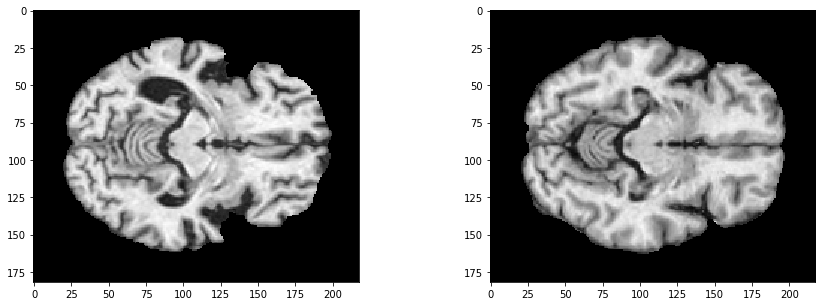

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].imshow(X_f[0][:,:,60], cmap='gray')
axs[1].imshow(X_f[1][:,:,60], cmap='gray')

In [17]:
X_f.shape

(88, 182, 218, 182)

In [18]:
import h5py

In [19]:
h5 = h5py.File('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_f.h5', 'w')
h5.create_dataset('X', data=X_f, compression='gzip', compression_opts=9)
h5.create_dataset('y', data=y_f, compression='gzip', compression_opts=9)
h5.close()

In [20]:
h5 = h5py.File('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_m.h5', 'w')
h5.create_dataset('X', data=X_m, compression='gzip', compression_opts=9)
h5.create_dataset('y', data=y_m, compression='gzip', compression_opts=9)
h5.close()

In [21]:
h5 = h5py.File('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_60_73.h5', 'w')
h5.create_dataset('X', data=X_60_73, compression='gzip', compression_opts=9)
h5.create_dataset('y', data=y_60_73, compression='gzip', compression_opts=9)
h5.close()

In [22]:
h5 = h5py.File('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_73_78.h5', 'w')
h5.create_dataset('X', data=X_73_78, compression='gzip', compression_opts=9)
h5.create_dataset('y', data=y_73_78, compression='gzip', compression_opts=9)
h5.close()

In [23]:
h5 = h5py.File('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/holdout_splits/ADNI_holdout_78_90.h5', 'w')
h5.create_dataset('X', data=X_78_90, compression='gzip', compression_opts=9)
h5.create_dataset('y', data=y_78_90, compression='gzip', compression_opts=9)
h5.close()

In [24]:
quit()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
